In [1]:
#Needed Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import re

import os
import sys

from tqdm import tqdm

import json
from pathlib import Path

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
tqdm.pandas()

sns.set(font_scale = 1.25)
sns.set_style("whitegrid")

categories = ['General Relation', 'Duplication', 'Temporal/Causal', 'Composition', 'Workflow']
cat_short = [ 'Com.', 'Gen.', 'Dup.', 'T/C', 'Wor.']
SOURCES = ['Apache', 'Hyperledger', 'IntelDAOS', 'JFrog', 'Jira', 'JiraEcosystem', 'MariaDB', 'Mindville', 'MongoDB', 'Qt', 'RedHat', 'Sakai', 'SecondLife', 'Sonatype', 'Spring']

pd.set_option('display.max_rows', None)

In [3]:
def load_data(source):
    #Loading Issues
    filename = '../../data/crawl/issues_'+source.lower()+'.csv'
    issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, sep=';', index_col=['issue_id'])
    
    #Loading Links
    filename = '../../data/crawl/clean_links_'+source.lower()+'.csv'
    links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0, sep=';')
    
    return issues, links

In [4]:
link_dict = {}
issue_dict = {}

for s in SOURCES:
    print(s.upper())
    issues, links = load_data(s)
    link_dict[s] = links
    issue_dict[s] = issues

APACHE
HYPERLEDGER
INTELDAOS
JFROG
JIRA
JIRAECOSYSTEM
MARIADB
MINDVILLE
MONGODB
QT
REDHAT
SAKAI
SECONDLIFE
SONATYPE
SPRING


In [5]:
for s in SOURCES:
    print(s.upper())
    issues = issue_dict[s]
    print(len(issues.projectid.unique()))
    print(issues.projectid.unique())

APACHE
646
['ZooKeeper' 'Apache Zipkin' 'Zeta Components' 'Zeppelin'
 'Apache YuniKorn' 'Yetus' 'Hadoop YARN' 'XWork' 'XmlSchema' 'XML-RPC'
 'XML Commons' 'XMLBeans' 'XMLGraphicsCommons' 'Xerces-P' 'Xerces2-J'
 'Xerces-C++' 'XBean' 'XAP' 'XalanJ2' 'XalanC' 'Struts 2' 'WSS4J' 'WSRP4J'
 'Axis-WSIF' 'WS-Commons' 'Wookie' 'Woden' 'Wink' 'Wicket'
 'Apache Whisker' 'Apache Whirr (retired)' 'Whimsy' 'Weex (Retired)'
 'Commons Weaver' 'Apache Wayang' 'Wave' 'Maven Wagon' 'WADI' 'VYSPER'
 'VXQuery (Retired)' 'Commons VFS' 'Velocity Tools' 'Velocity Sandbox'
 'Velocity' 'VCL' 'Commons Validator' 'Usergrid (Retired)' 'Apache Unomi'
 'UIMA' 'Apache Twill (Retired)' 'Tuweni' 'Tuscany' 'Test Project' 'TSIK'
 'Traffic Server' 'TripleSoup' 'MyFaces Trinidad' 'Tiles Request'
 'Turbine' 'Axis2 Transports' 'Commons Transaction' 'Apache Training'
 'Apache Trafodion (Retired)' 'Torque issues (old)' 'Torque' 'TOREE'
 'Avalon Metro Tools' 'TomEE' 'MyFaces Tomahawk' 'MyFaces Tobago' 'BRAND'
 'TinkerPop' 'Tile

In [6]:
def print_linktypes(SOURCE):
    
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    num_links = len(links)
    num_issues = len(issues)
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))

    projects = issues[['projectid']]

    temp = links.join(projects, how = 'inner', on='issue_id_1')
    temp = temp.join(projects, how = 'inner', on='issue_id_2', lsuffix='_1', rsuffix='_2')

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = temp.linktype.value_counts().rename_axis('linktype').reset_index(name='counts')
    try:
        same_ratio = round(temp['sameproject'].value_counts().loc[True]/len(temp)*100, 2)
    except:
        same_ratio = 0
    try:
        cross_ratio = round(temp['sameproject'].value_counts().loc[False]/len(temp)*100, 2)
    except:
        cross_ratio = 0

    blub = links.linktype.value_counts().rename_axis('linktype').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentages'] = blub['counts'].apply(lambda x: round(x/len(links),3)*100)
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in temp.linktype.value_counts().index:
        link_temp = temp[temp['linktype'] == i]
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
        link_index = blub.index[blub['linktype']==i]
        link_index = list(link_index)
        blub['sameproject'].iloc[link_index[0]] = same_ratio_temp
        blub['crossproject'].iloc[link_index[0]] = cross_ratio_temp
        
    return num_issues, num_links, len(links.linktype.unique()), round(len(link_set)/len(issue_set), 3), len(link_set), same_ratio, cross_ratio, blub

In [7]:
overview = pd.DataFrame(columns = ['Source', '#Issues', '#Links', '#Linktypes', '%IssuesWithLinks', '#LinkedIssues', "%SameProject", "%CrossProject"])
link_dist = pd.DataFrame(columns=['source', 'linktype', 'counts'])
j = 0
for s in SOURCES:
    i, l, ltu, pi, li, sr, cr, blub = print_linktypes(s)
    overview.loc[j] = [s, i, l, ltu, pi, li, sr, cr]
    
    j+=1
    
    frames = [link_dist, blub]
    #concatenate dataframes
    link_dist = pd.concat(frames, sort=False)

In [8]:
non_custom_types = (link_dist[link_dist['linktype']=='Subtask']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Epic-Relation']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Cloners']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Cloners (old)']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Relate']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Relates']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Related']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Reference']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Relationship']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Duplicate']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Blocker']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Blocked']['counts'].sum()
                    +link_dist[link_dist['linktype']=='Blocks']['counts'].sum())

In [9]:
non_custom_types/link_dist.counts.sum()

0.8130648804470748

In [10]:
blub = overview[['Source', '#Issues', '#Links', '#Linktypes',
           '%IssuesWithLinks', 
           '%CrossProject',]]

blub['%IssuesWithLinks'] = blub['%IssuesWithLinks'].apply(lambda x: str(round(x*100,1))+'%')
blub['%CrossProject'] = blub['%CrossProject'].apply(lambda x: str(round(x,1))+'%')

print(blub.to_latex(index=False))  

\begin{tabular}{lrrrll}
\toprule
       Source &  \#Issues &  \#Links &  \#Linktypes & \%IssuesWithLinks & \%CrossProject \\
\midrule
       Apache &  1014926 &  255767 &          22 &            28.5\% &          5.2\% \\
  Hyperledger &    28146 &   16304 &           8 &            54.9\% &          4.6\% \\
    IntelDAOS &     9474 &    2599 &          13 &            30.8\% &          3.3\% \\
        JFrog &    15535 &    3229 &          11 &            28.6\% &          8.2\% \\
         Jira &   274545 &   99819 &          19 &            46.7\% &         43.4\% \\
JiraEcosystem &    41866 &   11398 &          20 &            33.0\% &          6.8\% \\
      MariaDB &    31229 &   14618 &           8 &            44.5\% &          2.5\% \\
    Mindville &     2134 &      44 &           4 &             4.0\% &          4.5\% \\
      MongoDB &   137172 &   63821 &          15 &            45.2\% &         19.1\% \\
           Qt &   148579 &   40105 &          12 &            30.

In [11]:
type_dict={'Backports': 'Workflow', 
           
    'Blocked': 'Temporal/Causal',
    'Blocker': 'Temporal/Causal',
    'Blocks': 'Temporal/Causal',
           
    'Bonfire Testing': 'Workflow', 
    'Bonfire testing': 'Workflow', 
    'Git Code Review': 'Workflow', 
    'Testing': 'Workflow',
           
    'Causality': 'Temporal/Causal', 
    'Cause': 'Temporal/Causal',
    'Caused': 'Temporal/Causal', 
    'Problem/Incident': 'Temporal/Causal',
           
    'Child-Issue': 'Composition', 
    'Parent Feature': 'Composition',
    'Parent/Child': 'Composition',
    'multi-level hierarchy [GANTT]': 'Composition',
    'Parent-Relation': 'Composition',
           
    'Cloners': 'Duplication', 
    'Cloners (old)': 'Duplication', 
           
    'Collection': 'Composition', 
    'Container': 'Composition', 
    'Contains(WBSGantt)': 'Composition', 
    'Incorporate': 'Composition', 
    'Incorporates': 'Composition', 
    'Part': 'Composition',
    'PartOf': 'Composition',
    'Superset': 'Composition', 
           
    'Completes': 'Workflow', 
    'Fixes': 'Workflow',
    'Resolve': 'Workflow',
           
    'Depend': 'Temporal/Causal', 
    'Dependency': 'Temporal/Causal', 
    'Dependent': 'Temporal/Causal', 
    'Depends': 'Temporal/Causal', 
    'Gantt Dependency': 'Temporal/Causal',
    'dependent': 'Temporal/Causal',
           
    'Derived': 'Workflow',
           
    'Detail': 'Workflow', 
           
    'Documentation': 'Workflow',
    'Documented': 'Workflow',
    
    'Duplicate': 'Duplication',
           
    'Epic': 'Composition', 
    'Epic-Relation': 'Composition',
    
    'Finish-to-Finish link (WBSGantt)': 'Temporal/Causal', 
    'Gantt End to End': 'Temporal/Causal', 
    'Gantt: finish-finish': 'Temporal/Causal',
    'finish-finish [GANTT]': 'Temporal/Causal', 
    
    'Gantt End to Start': 'Temporal/Causal', 
    'Gantt: finish-start': 'Temporal/Causal',
    'finish-start [GANTT]': 'Temporal/Causal',

    'Gantt Start to Start': 'Temporal/Causal', 
    
    'Gantt: start-finish': 'Temporal/Causal', 
    
    'Follows': 'Temporal/Causal', 
    'Sequence': 'Temporal/Causal', 
    
    'Implement': 'Workflow', 
    'Implements': 'Workflow', 
    
    'Issue split': 'Composition',
    'Split': 'Composition',
    'Work Breakdown': 'Composition',
    
    'Preceded By': 'Temporal/Causal', 
    
    'Reference': 'General Relation',
    'Relate': 'General Relation',
    'Related': 'General Relation', 
    'Relates': 'General Relation',
    'Relationship': 'General Relation',
    
    'Regression': 'Workflow', 
    
    'Replacement': 'Duplication',
    
    'Required': 'Temporal/Causal', 
    
    'Supercedes': 'Workflow',
    'Supersede': 'Workflow',
    'Supersession': 'Workflow', 
    
    'Test': 'Workflow', 
    'Tested': 'Workflow',
    
    'Trigger': 'Workflow',
           
    'Subtask': 'Composition'}

In [12]:
def print_cleaned_linktypes(SOURCE):  
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))

    links['category'] = links['linktype'].map(type_dict)
            
    projects = issues[['projectid']]

    temp = links.join(projects, how = 'inner', on='issue_id_1')
    temp = temp.join(projects, how = 'inner', on='issue_id_2', lsuffix='_1', rsuffix='_2')

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = links.category.value_counts().rename_axis('category').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentageOfLinks'] = blub['counts'].apply(lambda x: round(x/len(links),10)*100)
    blub['percentagesOfIssues'] = 0
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in range(len(blub)):
        category = blub['category'].iloc[i]
        link_temp = temp[temp['category'] == category]
        lt_set = set(link_temp['issue_id_1']).union(set(link_temp['issue_id_2']))
        blub['percentagesOfIssues'].iloc[i] = round(len(lt_set)/len(issue_set),10)*100
        
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
            
        blub['sameproject'].iloc[i] = same_ratio_temp
        blub['crossproject'].iloc[i] = cross_ratio_temp
        
    return len(links.category.unique()), blub

In [13]:
overview_cl = pd.DataFrame(columns=['Source', '#Linktypes'])
cat_dist_cl = pd.DataFrame(columns=['source', 'category', 'counts'])
j = 0
for s in SOURCES:
    catu, blub = print_cleaned_linktypes(s)
    overview_cl.loc[j] = [s, catu]
    
    j+=1
    
    frames = [cat_dist_cl, blub]
    #concatenate dataframes
    cat_dist_cl = pd.concat(frames, sort=False)

In [14]:
cat_dist_cl.groupby(['category']).agg({'counts': ['sum'], 'percentageOfLinks': ['mean'], 'sameproject': ['mean'], 'crossproject': ['mean']})

,counts,percentageOfLinks,sameproject,crossproject
,sum,mean,mean,mean
category,,,,
Composition,210335,32.553657,98.079286,1.920714
Duplication,102395,16.773693,92.395714,7.604286
General Relation,225138,35.610431,87.464286,12.535714
Temporal/Causal,95755,13.174887,83.732857,16.267143
Workflow,16290,3.183273,82.279091,17.720909


In [15]:
pivot = pd.pivot_table(cat_dist_cl, values='percentageOfLinks', index=['source'],
                    columns=['category'], aggfunc=np.sum)
pivot = pivot[['Composition', 'General Relation', 'Duplication', 'Temporal/Causal', 'Workflow']]
pivot

category,Composition,General Relation,Duplication,Temporal/Causal,Workflow
source,,,,,
Apache,42.735771,28.284337,11.825607,13.795368,3.358917
Hyperledger,67.658243,17.216634,6.838813,8.243376,0.042934
IntelDAOS,10.542516,39.322816,11.158138,30.050019,0.654098
JFrog,37.410963,27.376897,20.749458,8.206875,6.255807
Jira,5.112253,63.762410,24.595518,2.990413,3.539406
JiraEcosystem,47.271451,22.925075,17.038077,11.852957,0.894894
MariaDB,20.584211,51.060337,9.399371,18.956082,NaN
Mindville,NaN,43.181818,54.545455,2.272727,NaN
MongoDB,18.471976,39.910061,13.771329,24.621990,3.223077


In [16]:
print(pivot.round(1).to_latex())

\begin{tabular}{lrrrrr}
\toprule
category &  Composition &  General Relation &  Duplication &  Temporal/Causal &  Workflow \\
source        &              &                   &              &                  &           \\
\midrule
Apache        &         42.7 &              28.3 &         11.8 &             13.8 &       3.4 \\
Hyperledger   &         67.7 &              17.2 &          6.8 &              8.2 &       0.0 \\
IntelDAOS     &         10.5 &              39.3 &         11.2 &             30.1 &       0.7 \\
JFrog         &         37.4 &              27.4 &         20.7 &              8.2 &       6.3 \\
Jira          &          5.1 &              63.8 &         24.6 &              3.0 &       3.5 \\
JiraEcosystem &         47.3 &              22.9 &         17.0 &             11.9 &       0.9 \\
MariaDB       &         20.6 &              51.1 &          9.4 &             19.0 &       NaN \\
Mindville     &          NaN &              43.2 &         54.5 &              2.

In [17]:
cat_order = ['Composition', 'General Relation', 'Duplication', 'Temporal/Causal', 'Workflow']

In [18]:
pivot.median()

category
Composition         30.508958
General Relation    34.399919
Duplication         12.967119
Temporal/Causal     11.966445
Workflow             3.223077
dtype: float64

In [19]:
tidy2 = cat_dist_cl.melt(id_vars='category').rename(columns=str.title)
tidy = tidy2[(tidy2['Variable']=='percentageOfLinks')]

In [20]:
tidy_short = tidy[tidy['Category'].isin(categories)]

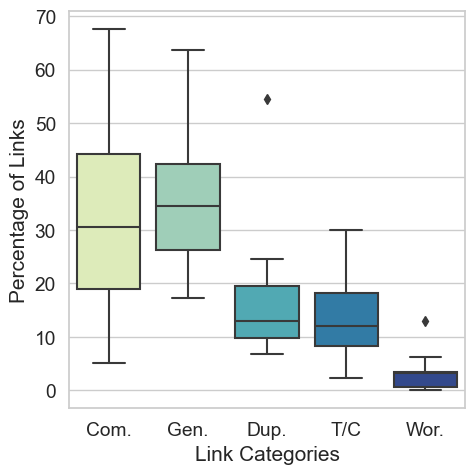

In [21]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

# plt.xticks(rotation=45)
ax = sns.boxplot(x='Category', y='Value', data=tidy_short, order=cat_order,  palette="YlGnBu")

ax.set(xlabel ="Link Categories", ylabel = "Percentage of Links")

ax.set_xticklabels(cat_short)

plt.tight_layout()
        
plt.savefig('pictures/link_cat_usage_cleaned.png', dpi = 300)


In [22]:
tidy3 = cat_dist_cl.melt(id_vars='category').rename(columns=str.title)
tidy4 = tidy3[(tidy3['Variable']=='percentagesOfIssues')]

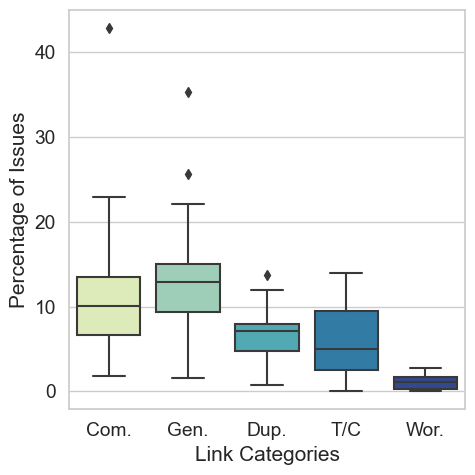

In [23]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

# plt.xticks(rotation=45)
ax = sns.boxplot(x='Category', y='Value', data=tidy4, order=cat_order,  palette="YlGnBu")

ax.set(xlabel ="Link Categories", ylabel = "Percentage of Issues")

ax.set_xticklabels(cat_short)

plt.tight_layout()
        
plt.savefig('pictures/link_cat_usage_issues_cleaned.png', dpi = 300)


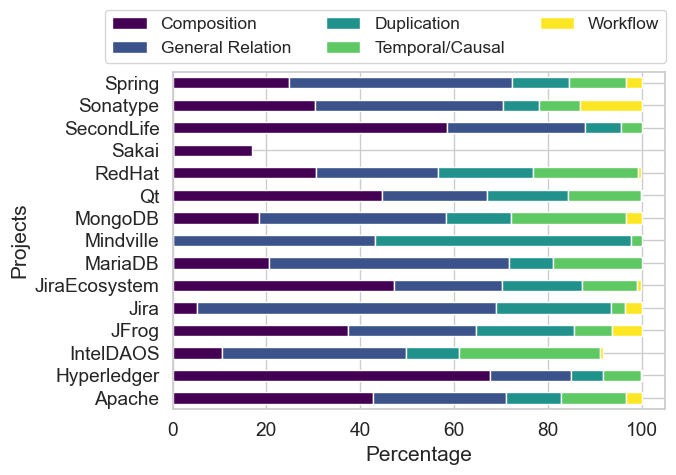

In [24]:
f, (ax) = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

fig = plt.gcf()
# fig.set_size_inches(10, 10)

ax = pivot.plot(kind='barh', stacked=True, mark_right = True, ax=ax, cmap="viridis")
ax.set(xlabel ="Percentage", ylabel = "Projects")

plt.legend(bbox_to_anchor=(-0.155, 1, 1, 0), ncol=3, fontsize='small')

plt.tight_layout()

ax.figure.savefig("pictures/link_cat_distribution_cleaned.png")